<a href="https://colab.research.google.com/github/samirsebbah/mec-mini-projects/blob/master/FeaturesSelection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'leap-atmospheric-physics-ai-climsim:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F56537%2F8877088%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240921%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240921T025902Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4f30059feb9eaeb7696f14f32f3de774fb66a49f2d2684e0b9a568eef830452970169fd4ea8b2e42a989e1b45c23d8a6e58dcb4c9d0f2e4bfb1114f5977069c8e61c88efedf91ce6d720a0278d2c3921b74fb49e838a4f011098dc2c4be4b7faa36ca328c5108bf8f88f331909e83177290897944ef7490379db7ec2346c800f61063d14101516d2aff9a15bcc9e4ba7e34b81a52b18d20ae6035dd21cd2389288265492329491e3cf0f31eca94c7194911c6b2c98dfa321267828de5a6c8dc6c9348dcca2c7336dcb276c02db1280804f8d03010de0c83981e73631178ccf9c96d6884096b43752233f9a6e213a30a29aca53f8014abf17be198906fbce8629'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[                                                  ] 1101783040 bytes downloaded

In [ ]:
%%capture

import numpy as np
import pandas as pd

from numpy import random

import os
import time

# plots
import matplotlib.pyplot as plt
import seaborn as sns

# polars as a better alternative to pandas
import polars as pl


## Options and input data/parameters

In [ ]:
# configs and params

pd.set_option('display.max_columns', None) # display all columns
my_seed = 43

my_colors = ('darkblue','darkgreen','darkred')

# input folder of dataset
dataset_input_folder = '/kaggle/input/leap-atmospheric-physics-ai-climsim'
train_ds = dataset_input_folder +'/train.csv'
test_ds = dataset_input_folder +'/test.csv'
submission_ds = dataset_input_folder +'/sample_submission.csv'

These helper methods are used to sample the data and pull the features and the target variables from input data

In [ ]:
# sample the data
import re
def batch_reader (NBR_BATCHES, BATCH_SIZE, input_file):
    reader = pl.read_csv_batched(input_file, batch_size=BATCH_SIZE)
    return reader.next_batches(NBR_BATCHES)


df_sub = batch_reader (1, 1, submission_ds)[0].to_pandas()

targets = df_sub.columns.to_list()
targets.remove('sample_id')
target_scalers_cols = targets
target_composits_cols = list()

target_composits = "ptend_t,ptend_q0001,ptend_q0002,ptend_q0003,ptend_u,ptend_v".split(",")

all_elts_of_composit_targets = dict()
for pattern in target_composits:
    all_elts_of_composit_targets[pattern] = [x for x in targets if re.match(pattern + "_[0-9]+$",x)]
    target_scalers_cols = [x for x in target_scalers_cols if x not in all_elts_of_composit_targets[pattern]]
    target_composits_cols.extend(all_elts_of_composit_targets[pattern]) # keep a list of all columns

# features
df_train = batch_reader (1, 1, train_ds)[0].to_pandas()

features = [x for x in df_train.columns.tolist() if x not in ['sample_id']+targets]
feature_scalers_cols = features
feature_composits_cols = list()

feature_composits = "state_t,state_q0001,state_q0002,state_q0003,state_u,state_v,pbuf_ozone,pbuf_CH4,pbuf_N2O".split(",")

all_elts_of_composit_features = dict()
for pattern in feature_composits:
    all_elts_of_composit_features[pattern] = [x for x in features if re.match(pattern + "_[0-9]+$",x)]
    feature_scalers_cols = [x for x in feature_scalers_cols if x not in all_elts_of_composit_features[pattern]]
    feature_composits_cols.extend(all_elts_of_composit_features[pattern])

In [ ]:
#input_data_batches = batch_reader (1, 100_000, train_ds)
#type(input_data_batches)
#for batch in input_data_batches:
#    df = batch.to_pandas()
#    df.drop('sample_id', axis=1, inplace=True)
#    print(df)
# ! pip install seaborn

## Visualize the features' distributions in the composit features

<p> Helper methods to sample and visualize the features distributions and correlations </p>

In [ ]:
# first composit feature
import warnings
warnings.filterwarnings('ignore')

def display_composit_feature (comp_feature, df, color_in):
    df = df.replace([np.inf, -np.inf], np.nan)
    v = all_elts_of_composit_features[comp_feature]
    fig, axs = plt.subplots(int(len(v)/4), 4, figsize=(50,100)) # 10 X 6
    ax = axs.flatten()

    for i, col in enumerate(v):
        sns.histplot(df[col], ax=ax[i])
        ax[i].set_title(col)

    fig.tight_layout(w_pad=6, h_pad=4)
    plt.show()

def display_scaler_features (df, color_in):
    df = df.replace([np.inf, -np.inf], np.nan)
    v = feature_scalers_cols
    fig, axs = plt.subplots(int(len(v)/4), 4, figsize=(50,100)) # 10 X 6
    ax = axs.flatten()

    for i, col in enumerate(v):
        sns.histplot(df[col], ax=ax[i])
        ax[i].set_title(col)

    fig.tight_layout(w_pad=6, h_pad=4)
    plt.show()


def display_batch_i_key_j(batch_id, key_id, composit=True):
    batch = input_data_batches[batch_id]
    sub_df = batch.to_pandas()
    if composit:
        display_composit_feature(key_id,sub_df, my_colors[np.random.choice(np.arange(0, len(my_colors)))])
    else:
        display_scaler_features(sub_df, my_colors[np.random.choice(np.arange(0, len(my_colors)))])

Read 3 batches of data

In [ ]:
# Sample the data - get a batch
input_data_batches = batch_reader (2, 100_000, train_ds) # get 3 batches of size=100_000 observations each

## Composit Feature state_t
Display stats in batch 1

In [ ]:
## Input feature: state_t
input_data_batches[0][all_elts_of_composit_features['state_t']].describe()


statistic,state_t_0,state_t_1,state_t_2,state_t_3,state_t_4,state_t_5,state_t_6,state_t_7,state_t_8,state_t_9,state_t_10,state_t_11,state_t_12,state_t_13,state_t_14,state_t_15,state_t_16,state_t_17,state_t_18,state_t_19,state_t_20,state_t_21,state_t_22,state_t_23,state_t_24,state_t_25,state_t_26,state_t_27,state_t_28,state_t_29,state_t_30,state_t_31,state_t_32,state_t_33,state_t_34,state_t_35,state_t_36,state_t_37,state_t_38,state_t_39,state_t_40,state_t_41,state_t_42,state_t_43,state_t_44,state_t_45,state_t_46,state_t_47,state_t_48,state_t_49,state_t_50,state_t_51,state_t_52,state_t_53,state_t_54,state_t_55,state_t_56,state_t_57,state_t_58,state_t_59
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",216.572079,230.29474,239.432406,249.113154,257.279144,260.537122,256.805289,248.508714,239.000649,232.245571,226.74554,222.364884,218.310798,214.843558,211.132163,207.121454,202.670664,200.045162,199.255795,200.80209,203.063691,205.970813,209.437514,213.199815,217.017653,220.830339,224.547658,228.159563,231.648106,235.030143,238.307974,241.509004,244.632909,247.680752,250.640928,253.496634,256.219668,258.790718,261.204167,263.442874,265.490366,267.345786,269.009929,270.508709,271.881396,273.166893,274.376698,275.529926,276.628344,277.659268,278.621384,279.528575,280.398116,281.247576,282.092047,282.939833,283.791974,284.637524,285.488374,286.347914
"""std""",5.67381,8.841674,7.461925,5.92444,5.763021,7.514639,8.80308,8.672554,7.805295,7.197876,6.720518,6.439372,6.315779,6.471786,7.269616,8.964126,11.53431,12.998729,11.320412,9.226741,5.740026,3.368849,3.114869,4.428162,6.169092,7.745762,9.157424,10.322657,11.292358,12.063057,12.672632,13.123811,13.449874,13.666919,13.795304,13.847225,13.83752,13.788906,13.732424,13.678583,13.631235,13.584839,13.533042,13.479576,13.436181,13.418676,13.425195,13.462658,13.530434,13.617344,13.713498,13.816552,13.926118,14.051952,14.207225,14.405079,14.663654,15.00162,15.328533,15.73877
"""min""",161.172605,184.841224,207.991598,222.561621,224.612114,224.161647,213.781956,205.330044,199.801016,194.719,192.101713,190.666526,190.685573,191.345976,192.23732,189.660028,176.324412,170.826556,176.52633,184.866355,192.38198,196.192745,196.250288,197.04819,197.305905,198.463378,198.678341,200.660923,203.905689,207.699272,209.798248,211.478895,213.271102,215.150624,217.095365,219.074118,221.081295,223.020232,224.865632,226.565342,228.069196,229.442999,230.62973,231.529605,232.295193,232.806678,233.304805,233.633777,233.304607,234.111614,234.995307,234.921233,234.739441,233.891563,233.752054,232.980484,232.636489,231.828039,231.471824,229.994354
"""25%""",213.990082,224.450388,234.163094,245.454975,254.853876,257.983502,253.359229,244.889208,235.786642,229.679035,224.357626,219.874688,215.136603,211.015301,206.128838,200.078357,192.627416,188.390771,189.418537,192.734578,198.478795,203.666457,208.235662,210.580277,212.419741,214.578813,216.886054,219.47964,222.200379,225.025843,227.915295,230.91484,233.901034,236.980717,240.031104,243.093165,246.025813,248.840435,251.522341,2

In [ ]:
display_batch_i_key_j(0, 'state_t')

Display stats in batch 2

In [ ]:
## Input feature: state_t

display_batch_i_key_j(1, 'state_t')

### Measure correlation of state_t features

In [ ]:
from scipy import stats
from scipy.stats.mstats import pearsonr

df = input_data_batches[0].to_pandas()
index_all_features = all_elts_of_composit_features['state_t']
correlationMatrix = pd.DataFrame(data=[],index=index_all_features, columns=index_all_features)
for i in index_all_features:
    for j in index_all_features:
        correlationMatrix.loc[i,j] = np.round(pearsonr(df.loc[:,i], df.loc[:,j])[0],2)


hc = correlationMatrix[correlationMatrix>0.8]
for cnt_col, col in enumerate(correlationMatrix.columns):
    for cnt_idx, idx in enumerate(hc.index):
        if cnt_idx>cnt_col: #symmetrical matrix
            if hc.loc[idx, col]>0.8 or hc.loc[idx, col]<0.8:
                print(f"correlation of {idx}, {col}, is {hc.loc[idx, col]}")

correlation of state_t_5, state_t_4, is 0.81
correlation of state_t_6, state_t_5, is 0.95
correlation of state_t_7, state_t_5, is 0.85
correlation of state_t_7, state_t_6, is 0.96
correlation of state_t_8, state_t_6, is 0.87
correlation of state_t_8, state_t_7, is 0.96
correlation of state_t_9, state_t_7, is 0.87
correlation of state_t_9, state_t_8, is 0.96
correlation of state_t_10, state_t_8, is 0.87
correlation of state_t_10, state_t_9, is 0.97
correlation of state_t_11, state_t_9, is 0.89
correlation of state_t_11, state_t_10, is 0.97
correlation of state_t_12, state_t_10, is 0.88
correlation of state_t_12, state_t_11, is 0.96
correlation of state_t_13, state_t_11, is 0.85
correlation of state_t_13, state_t_12, is 0.95
correlation of state_t_14, state_t_12, is 0.83
correlation of state_t_14, state_t_13, is 0.94
correlation of state_t_15, state_t_13, is 0.82
correlation of state_t_15, state_t_14, is 0.95
correlation of state_t_16, state_t_14, is 0.86
correlation of state_t_17, state

### Observations
Looking thru the 2 sampled batches of data
<ol>
  <li> Domains of the different distributions seem to span the same range (within this composit feature)</li>
    <li>Features state_t_0 to state_t_16 seems to have the same data distributions.</li>
    <li>Features state_t_17 to state_t_23 seems to have the same data distributions.</li>
    <li> Features state_t_23 to state_t_60 seem have the same data distributions (an indicator that these features might be highly correlated). </li>
</ol>
The observations above might be a good indicator of the relevant features needed in training this model


## Composit Feature state_q0001


In [ ]:
## Input feature: state_q0001
input_data_batches[0][all_elts_of_composit_features['state_q0001']].describe()


statistic,state_q0001_0,state_q0001_1,state_q0001_2,state_q0001_3,state_q0001_4,state_q0001_5,state_q0001_6,state_q0001_7,state_q0001_8,state_q0001_9,state_q0001_10,state_q0001_11,state_q0001_12,state_q0001_13,state_q0001_14,state_q0001_15,state_q0001_16,state_q0001_17,state_q0001_18,state_q0001_19,state_q0001_20,state_q0001_21,state_q0001_22,state_q0001_23,state_q0001_24,state_q0001_25,state_q0001_26,state_q0001_27,state_q0001_28,state_q0001_29,state_q0001_30,state_q0001_31,state_q0001_32,state_q0001_33,state_q0001_34,state_q0001_35,state_q0001_36,state_q0001_37,state_q0001_38,state_q0001_39,state_q0001_40,state_q0001_41,state_q0001_42,state_q0001_43,state_q0001_44,state_q0001_45,state_q0001_46,state_q0001_47,state_q0001_48,state_q0001_49,state_q0001_50,state_q0001_51,state_q0001_52,state_q0001_53,state_q0001_54,state_q0001_55,state_q0001_56,state_q0001_57,state_q0001_58,state_q0001_59
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000002,0.000003,0.000005,0.000008,0.000014,0.000024,0.000041,0.000067,0.000104,0.000153,0.000215,0.000295,0.000394,0.000516,0.000663,0.000835,0.001032,0.001256,0.001511,0.001803,0.002127,0.002479,0.002857,0.003259,0.003691,0.004152,0.004629,0.005099,0.005548,0.005962,0.006331,0.006672,0.006996,0.007312,0.007624,0.007935,0.008235,0.008509,0.008741,0.008926,0.009085,0.009245
"""std""",2.3041e-8,3.1002e-8,5.1449e-8,8.4148e-8,1.2807e-7,1.7323e-7,2.0190e-7,2.1815e-7,2.2734e-7,2.3036e-7,2.2460e-7,2.0082e-7,1.5890e-7,1.6388e-7,2.5357e-7,4.1408e-7,3.6596e-7,3.8208e-7,7.3030e-7,0.000001,0.000002,0.000004,0.000007,0.000016,0.000034,0.000063,0.000107,0.000168,0.000247,0.000343,0.000456,0.000589,0.000738,0.000898,0.001066,0.00124,0.001421,0.001611,0.00181,0.00202,0.00224,0.002463,0.00269,0.002917,0.003145,0.003372,0.003586,0.003789,0.003975,0.004149,0.004319,0.004491,0.004673,0.004865,0.00506,0.005243,0.0054,0.005518,0.00561,0.005703
"""min""",0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,9.6767e-7,9.0920e-7,8.5136e-7,8.2834e-7,8.2110e-7,8.3780e-7,8.7028e-7,9.5207e-7,9.6018e-7,8.2712e-7,2.7514e-7,3.1594e-8,3.5270e-8,2.0152e-7,5.2609e-7,0.000001,0.000002,0.000002,0.000002,0.000003,0.000003,0.000004,0.000005,0.000005,0.000005,0.000007,0.00001,0.000012,0.000017,0.000028,0.000032,0.000038,0.000044,0.000051,0.000063,0.00007,0.000081,0.000092,0.000098,0.000102,0.000108,0.000112,0.00011,0.000114,0.000119,0.000115,0.000112,0.000109,0.000107,0.000095,0.000084,0.000078,0.000067,0.00006
"""25%""",0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000002,0.000003,0.000005,0.000008,0.000012,0.000017,0.000021,0.000026,0.000032,0.000042,0.000055,0.000072,0.000096,0.000129,0.000172,0.000228,0.000301,0.00039,0.000496,0.00062,0.000765,0.000927,0.001101,0.001308,0.001543,0.001777,0.002029,0.002293,0.00

In [ ]:
display_batch_i_key_j(0, 'state_q0001')

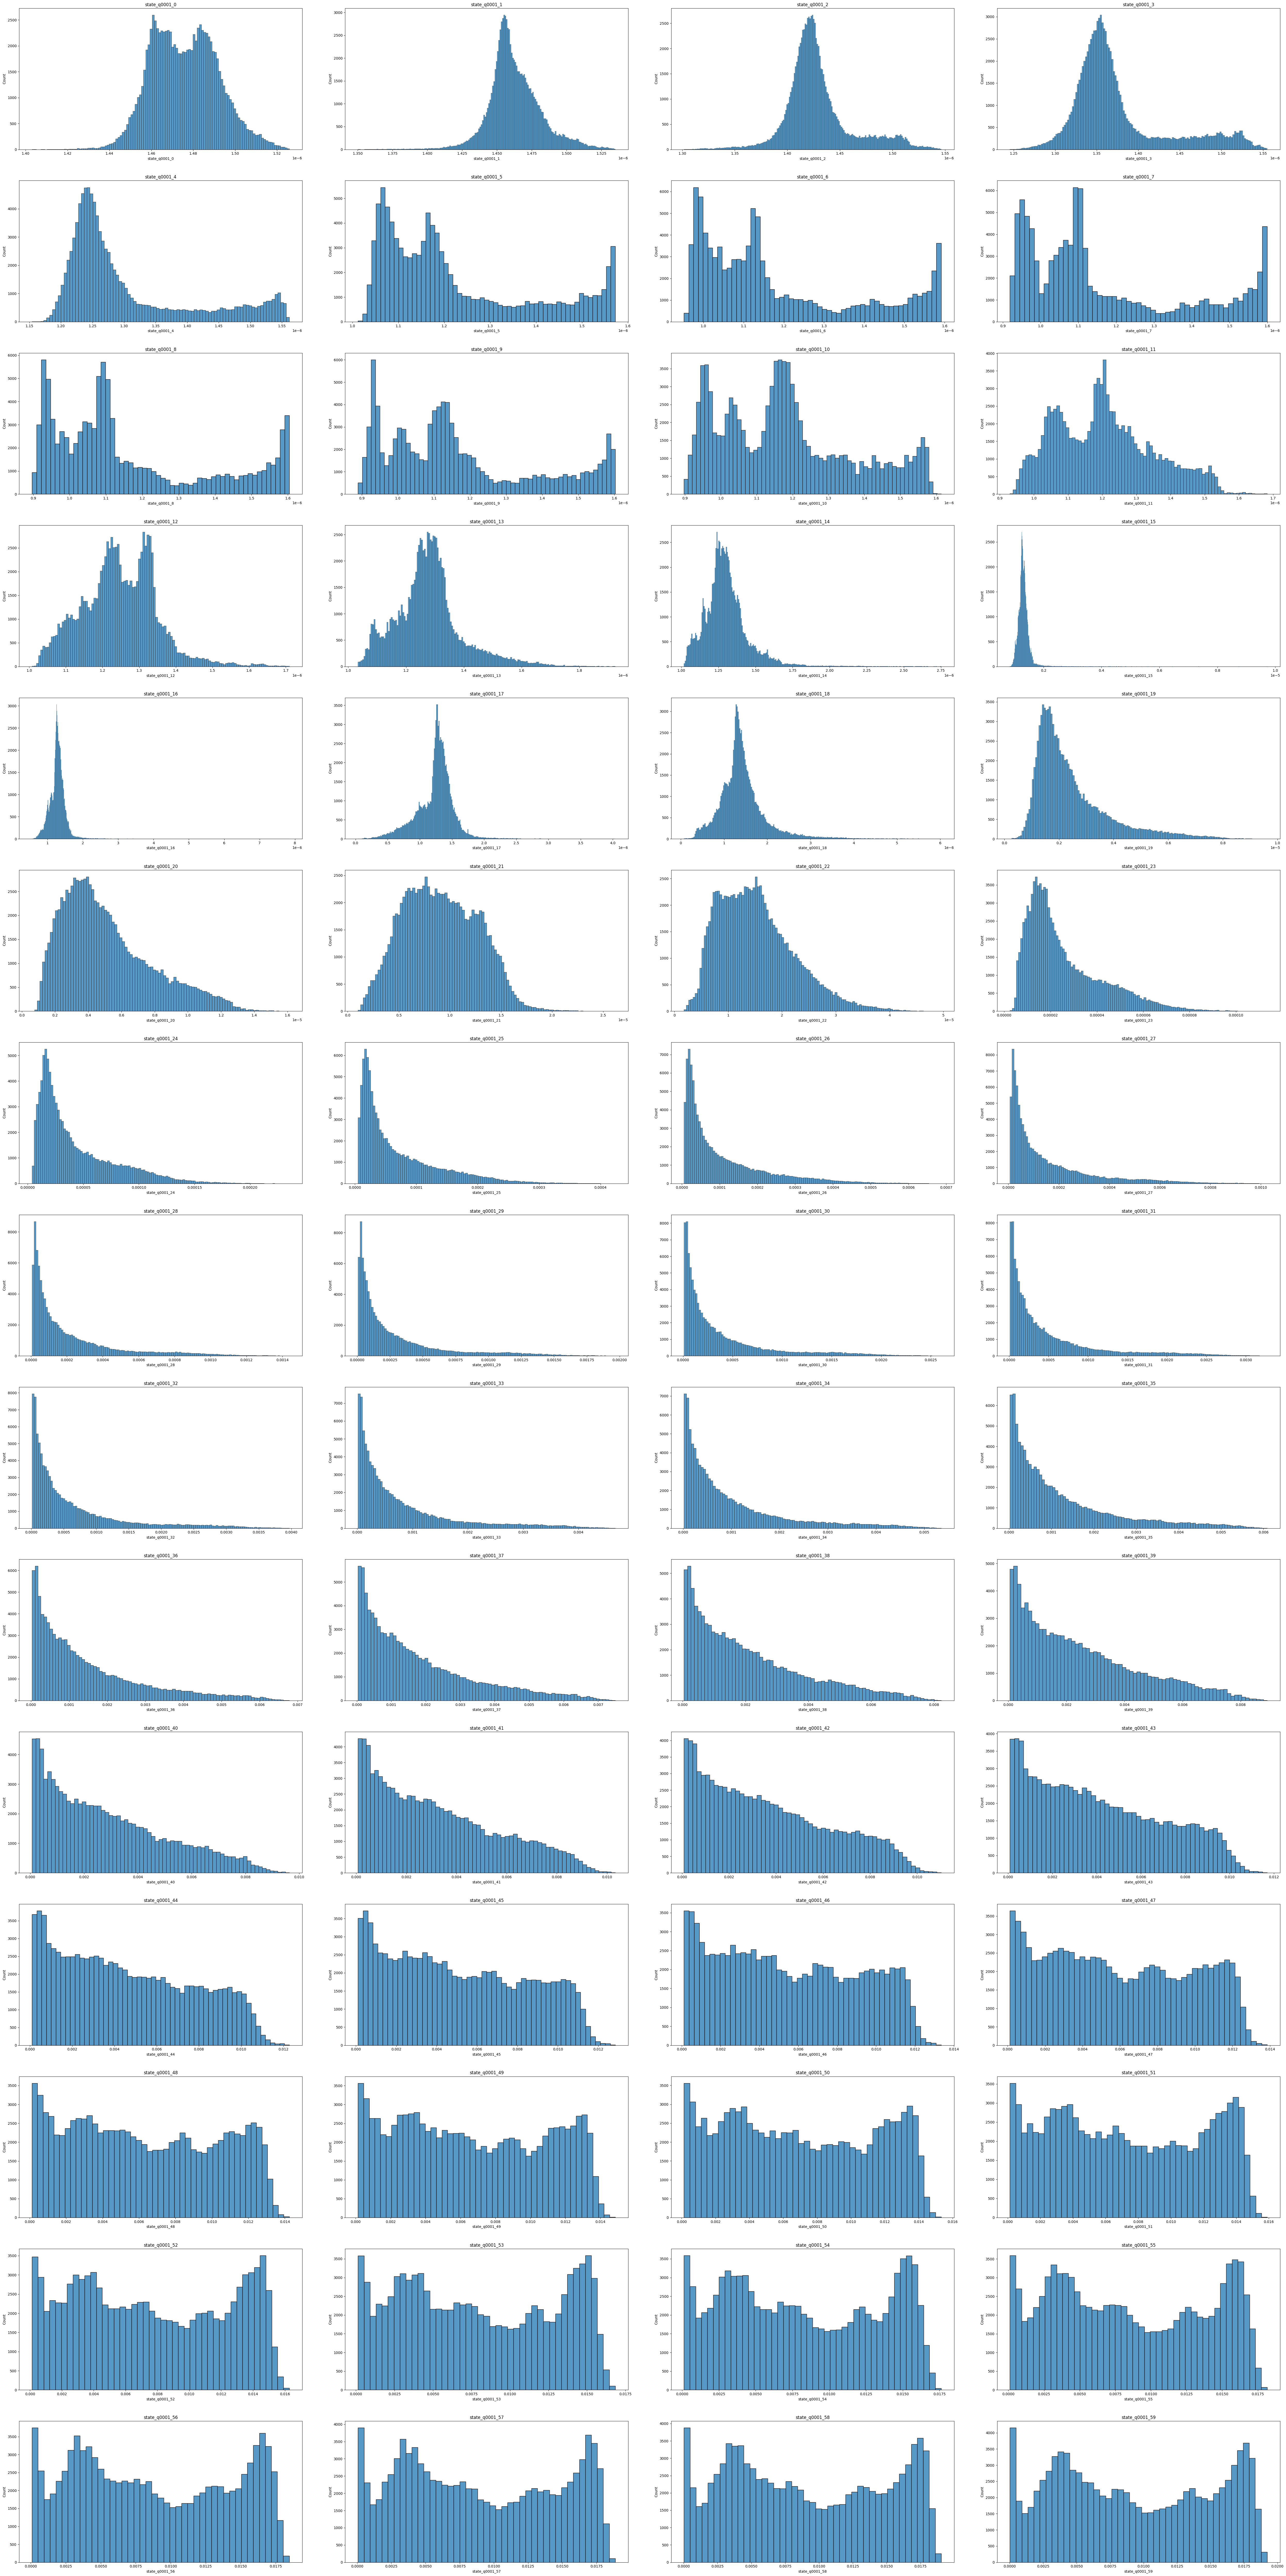

In [ ]:
display_batch_i_key_j(1, 'state_q0001')

### Measure correlation of state_q0001 features

In [ ]:
df = input_data_batches[0].to_pandas()
index_all_features = all_elts_of_composit_features['state_q0001']
correlationMatrix = pd.DataFrame(data=[],index=index_all_features, columns=index_all_features)
for i in index_all_features:
    for j in index_all_features:
        correlationMatrix.loc[i,j] = np.round(pearsonr(df.loc[:,i], df.loc[:,j])[0],2)


hc = correlationMatrix[correlationMatrix>0.8]
for cnt_col, col in enumerate(correlationMatrix.columns):
    for cnt_idx, idx in enumerate(hc.index):
        if cnt_idx>cnt_col: #symmetrical matrix
            if hc.loc[idx, col]>0.8 or hc.loc[idx, col]<0.8:
                print(f"correlation of {idx}, {col}, is {hc.loc[idx, col]}")

correlation of state_q0001_1, state_q0001_0, is 0.89
correlation of state_q0001_2, state_q0001_1, is 0.91
correlation of state_q0001_3, state_q0001_2, is 0.94
correlation of state_q0001_4, state_q0001_2, is 0.89
correlation of state_q0001_5, state_q0001_2, is 0.83
correlation of state_q0001_4, state_q0001_3, is 0.97
correlation of state_q0001_5, state_q0001_3, is 0.93
correlation of state_q0001_6, state_q0001_3, is 0.9
correlation of state_q0001_7, state_q0001_3, is 0.87
correlation of state_q0001_8, state_q0001_3, is 0.82
correlation of state_q0001_5, state_q0001_4, is 0.98
correlation of state_q0001_6, state_q0001_4, is 0.96
correlation of state_q0001_7, state_q0001_4, is 0.94
correlation of state_q0001_8, state_q0001_4, is 0.89
correlation of state_q0001_6, state_q0001_5, is 0.99
correlation of state_q0001_7, state_q0001_5, is 0.98
correlation of state_q0001_8, state_q0001_5, is 0.94
correlation of state_q0001_9, state_q0001_5, is 0.87
correlation of state_q0001_7, state_q0001_6, is

## TODO what others are saying about the correlations within composit features

### Observations

Looking thru the 2 sampled batches of data
<ol>
   <li> Domains of the different distributions seem to span a wider range range than the previous feature. Domains of the features is in the vicinity of 0 (log normalization to boost those observations)</li>
   <li> As with the previous feature, 3 types of distributions can be noticed in the graphs above</li>
<ol>    
    
The observations above might be a good indicator of the relevant features needed in training this model

## Composit Feature state_q0002

In [ ]:
input_data_batches[0][all_elts_of_composit_features['state_q0002']].describe()

statistic,state_q0002_0,state_q0002_1,state_q0002_2,state_q0002_3,state_q0002_4,state_q0002_5,state_q0002_6,state_q0002_7,state_q0002_8,state_q0002_9,state_q0002_10,state_q0002_11,state_q0002_12,state_q0002_13,state_q0002_14,state_q0002_15,state_q0002_16,state_q0002_17,state_q0002_18,state_q0002_19,state_q0002_20,state_q0002_21,state_q0002_22,state_q0002_23,state_q0002_24,state_q0002_25,state_q0002_26,state_q0002_27,state_q0002_28,state_q0002_29,state_q0002_30,state_q0002_31,state_q0002_32,state_q0002_33,state_q0002_34,state_q0002_35,state_q0002_36,state_q0002_37,state_q0002_38,state_q0002_39,state_q0002_40,state_q0002_41,state_q0002_42,state_q0002_43,state_q0002_44,state_q0002_45,state_q0002_46,state_q0002_47,state_q0002_48,state_q0002_49,state_q0002_50,state_q0002_51,state_q0002_52,state_q0002_53,state_q0002_54,state_q0002_55,state_q0002_56,state_q0002_57,state_q0002_58,state_q0002_59
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",2.0765e-33,2.4381e-33,3.0168e-33,3.6833e-33,4.6116e-33,6.0610e-33,6.5564e-33,5.2443e-33,2.5460e-33,6.3472e-34,8.3633e-35,6.6374e-36,8.6937e-40,4.0179e-45,2.1736e-50,2.0544e-55,1.9308e-53,3.6331e-47,1.6421e-43,1.6887e-40,1.0511e-37,3.0327e-35,6.2634e-33,2.1901e-30,5.5903e-27,2.5039e-23,1.2073e-19,1.1114e-15,2.5163e-11,1.3257e-8,2.7985e-7,0.000001,0.000002,0.000003,0.000004,0.000005,0.000006,0.000007,0.000009,0.00001,0.000012,0.000013,0.000016,0.000019,0.000022,0.000025,0.000027,0.000029,0.000029,0.000028,0.000027,0.000026,0.000023,0.00002,0.000017,0.000013,0.00001,0.000008,0.000006,0.000003
"""std""",1.2428e-33,1.7980e-33,2.8215e-33,4.2826e-33,6.7275e-33,1.0942e-32,1.3331e-32,1.1647e-32,6.0037e-33,1.5518e-33,2.1504e-34,1.7799e-35,3.6819e-39,1.8082e-44,2.1359e-49,4.2422e-53,3.8722e-51,8.6208e-45,3.4889e-41,2.7369e-38,1.7123e-35,4.9323e-33,9.9713e-31,2.9370e-28,9.5465e-25,4.8682e-21,1.9148e-17,7.3538e-14,1.1969e-9,1.6401e-7,0.000002,0.000006,0.000009,0.000012,0.000014,0.000016,0.000018,0.000019,0.00002,0.000022,0.000023,0.000025,0.000028,0.00003,0.000033,0.000036,0.000037,0.000038,0.000037,0.000036,0.000035,0.000033,0.000032,0.00003,0.000027,0.000025,0.000023,0.000021,0.000018,0.000011
"""min""",6.1654e-35,4.5675e-35,2.9622e-35,1.1463e-35,5.2135e-36,1.2025e-36,1.4277e-37,2.0107e-38,3.5858e-39,1.8140e-39,1.3783e-40,3.1053e-42,6.3430e-50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",1.1520e-33,9.6557e-34,6.7100e-34,4.0638e-34,2.2237e-34,8.7490e-35,2.0661e-35,6.1744e-36,1.6477e-36,2.5958e-37,3.5398e-38,3.5897e-39,2.0437e-43,4.5024e-49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.3923e-19,4.8693e-11,2.7971e-9,1.7258e-8,4.6393e-8,1.1090e-7,2.1743e-7,3.7938e-7,6.2234e-7,0.000001,0.000001,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000001,7.6231e-7,3.7232e-7,1.5896e-7,6.8602e-8,3.0368e-8,1.3545e-8
"""50%""",1.8591e-33,1.9002e-33,1.8529e-33,1.6487e-33,8.4819e-3

In [ ]:
display_batch_i_key_j(0, 'state_q0002')

In [ ]:
display_batch_i_key_j(1, 'state_q0002')

## Composit Feature state_q0003

In [ ]:
input_data_batches[0][all_elts_of_composit_features['state_q0002']].describe()


statistic,state_q0002_0,state_q0002_1,state_q0002_2,state_q0002_3,state_q0002_4,state_q0002_5,state_q0002_6,state_q0002_7,state_q0002_8,state_q0002_9,state_q0002_10,state_q0002_11,state_q0002_12,state_q0002_13,state_q0002_14,state_q0002_15,state_q0002_16,state_q0002_17,state_q0002_18,state_q0002_19,state_q0002_20,state_q0002_21,state_q0002_22,state_q0002_23,state_q0002_24,state_q0002_25,state_q0002_26,state_q0002_27,state_q0002_28,state_q0002_29,state_q0002_30,state_q0002_31,state_q0002_32,state_q0002_33,state_q0002_34,state_q0002_35,state_q0002_36,state_q0002_37,state_q0002_38,state_q0002_39,state_q0002_40,state_q0002_41,state_q0002_42,state_q0002_43,state_q0002_44,state_q0002_45,state_q0002_46,state_q0002_47,state_q0002_48,state_q0002_49,state_q0002_50,state_q0002_51,state_q0002_52,state_q0002_53,state_q0002_54,state_q0002_55,state_q0002_56,state_q0002_57,state_q0002_58,state_q0002_59
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",2.0765e-33,2.4381e-33,3.0168e-33,3.6833e-33,4.6116e-33,6.0610e-33,6.5564e-33,5.2443e-33,2.5460e-33,6.3472e-34,8.3633e-35,6.6374e-36,8.6937e-40,4.0179e-45,2.1736e-50,2.0544e-55,1.9308e-53,3.6331e-47,1.6421e-43,1.6887e-40,1.0511e-37,3.0327e-35,6.2634e-33,2.1901e-30,5.5903e-27,2.5039e-23,1.2073e-19,1.1114e-15,2.5163e-11,1.3257e-8,2.7985e-7,0.000001,0.000002,0.000003,0.000004,0.000005,0.000006,0.000007,0.000009,0.00001,0.000012,0.000013,0.000016,0.000019,0.000022,0.000025,0.000027,0.000029,0.000029,0.000028,0.000027,0.000026,0.000023,0.00002,0.000017,0.000013,0.00001,0.000008,0.000006,0.000003
"""std""",1.2428e-33,1.7980e-33,2.8215e-33,4.2826e-33,6.7275e-33,1.0942e-32,1.3331e-32,1.1647e-32,6.0037e-33,1.5518e-33,2.1504e-34,1.7799e-35,3.6819e-39,1.8082e-44,2.1359e-49,4.2422e-53,3.8722e-51,8.6208e-45,3.4889e-41,2.7369e-38,1.7123e-35,4.9323e-33,9.9713e-31,2.9370e-28,9.5465e-25,4.8682e-21,1.9148e-17,7.3538e-14,1.1969e-9,1.6401e-7,0.000002,0.000006,0.000009,0.000012,0.000014,0.000016,0.000018,0.000019,0.00002,0.000022,0.000023,0.000025,0.000028,0.00003,0.000033,0.000036,0.000037,0.000038,0.000037,0.000036,0.000035,0.000033,0.000032,0.00003,0.000027,0.000025,0.000023,0.000021,0.000018,0.000011
"""min""",6.1654e-35,4.5675e-35,2.9622e-35,1.1463e-35,5.2135e-36,1.2025e-36,1.4277e-37,2.0107e-38,3.5858e-39,1.8140e-39,1.3783e-40,3.1053e-42,6.3430e-50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",1.1520e-33,9.6557e-34,6.7100e-34,4.0638e-34,2.2237e-34,8.7490e-35,2.0661e-35,6.1744e-36,1.6477e-36,2.5958e-37,3.5398e-38,3.5897e-39,2.0437e-43,4.5024e-49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.3923e-19,4.8693e-11,2.7971e-9,1.7258e-8,4.6393e-8,1.1090e-7,2.1743e-7,3.7938e-7,6.2234e-7,0.000001,0.000001,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000001,7.6231e-7,3.7232e-7,1.5896e-7,6.8602e-8,3.0368e-8,1.3545e-8
"""50%""",1.8591e-33,1.9002e-33,1.8529e-33,1.6487e-33,8.4819e-3

In [ ]:
display_batch_i_key_j(0, 'state_q0003')

In [ ]:
display_batch_i_key_j(1, 'state_q0003')

## Composit Feature state_q0004

In [ ]:
input_data_batches[0][all_elts_of_composit_features['state_u']].describe()

statistic,state_u_0,state_u_1,state_u_2,state_u_3,state_u_4,state_u_5,state_u_6,state_u_7,state_u_8,state_u_9,state_u_10,state_u_11,state_u_12,state_u_13,state_u_14,state_u_15,state_u_16,state_u_17,state_u_18,state_u_19,state_u_20,state_u_21,state_u_22,state_u_23,state_u_24,state_u_25,state_u_26,state_u_27,state_u_28,state_u_29,state_u_30,state_u_31,state_u_32,state_u_33,state_u_34,state_u_35,state_u_36,state_u_37,state_u_38,state_u_39,state_u_40,state_u_41,state_u_42,state_u_43,state_u_44,state_u_45,state_u_46,state_u_47,state_u_48,state_u_49,state_u_50,state_u_51,state_u_52,state_u_53,state_u_54,state_u_55,state_u_56,state_u_57,state_u_58,state_u_59
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",9.314656,7.317012,4.27432,-2.033449,-8.807852,-10.371672,-7.014803,-2.522347,0.950577,2.989412,3.957854,4.428656,4.893748,5.596522,6.663828,8.508432,11.512709,15.148348,18.298968,20.614422,22.055758,22.816596,23.051901,22.899455,22.445545,21.775993,20.955435,20.038284,19.044674,17.998139,16.914024,15.805785,14.685867,13.56431,12.458594,11.389308,10.377636,9.42609,8.537433,7.716089,6.959388,6.263283,5.62468,5.034376,4.486512,3.970417,3.483667,3.029315,2.615682,2.242237,1.904757,1.603319,1.337195,1.102803,0.903445,0.720838,0.536728,0.360631,0.191073,0.001075
"""std""",33.026423,32.268335,32.843954,33.873496,36.186471,36.030708,31.097734,25.517965,21.335359,18.326769,16.026455,14.222768,12.781104,11.733253,11.176739,11.017519,11.066666,11.814958,13.2473,14.758764,16.049618,16.748588,16.854014,16.569804,16.02175,15.289065,14.490319,13.690715,12.917872,12.167446,11.437431,10.745404,10.104916,9.523477,9.013516,8.566306,8.173959,7.832004,7.542609,7.301215,7.104281,6.949864,6.830767,6.749074,6.702467,6.688911,6.703672,6.739464,6.779395,6.819333,6.85758,6.885599,6.891047,6.858538,6.779167,6.650667,6.457001,6.168631,5.705393,5.051945
"""min""",-109.331609,-105.965608,-83.898377,-82.830285,-75.521026,-73.246191,-70.46082,-66.489062,-58.0544,-46.18496,-33.876198,-23.535874,-21.328991,-17.999493,-15.478234,-22.395364,-32.736004,-46.660744,-36.102654,-37.581614,-33.138009,-30.301352,-26.082463,-25.116064,-24.485093,-24.286929,-24.327636,-23.666228,-21.589842,-18.715789,-14.572311,-10.539506,-10.660666,-10.504391,-11.237311,-12.073557,-11.869267,-12.923392,-13.272905,-15.870487,-16.836523,-18.434027,-20.029736,-20.878728,-20.930848,-20.573897,-19.870906,-19.889292,-19.848083,-20.689361,-21.303931,-21.548105,-21.206854,-20.866923,-20.122042,-19.467933,-19.822716,-18.557994,-18.054313,-17.185251
"""25%""",-14.568456,-16.965064,-20.337893,-26.375644,-36.971323,-39.484923,-32.262058,-22.867661,-15.551239,-11.185031,-8.284311,-6.16709,-4.435615,-3.072527,-1.920901,-0.047714,3.432273,7.414257,9.93977,11.152695,11.358663,11.196261,10.825424,10.551285,10.282136,10.151229,9.881284,9.628923,9.305487,8.898642,8.454187,7.848791,7.181919,6.40542,5.66366,4.882917,4.069886,3.340012,2.614273,1.953344,1.317848,0.731059,0.138942,-0.395614,-0.877728,-1.305512,-1.700002,-2.119309,-2.496828,-2.843819,-3.195472,-3.535247,-3.857256,

In [ ]:
input_data_batches[0][all_elts_of_composit_features['state_v']].describe()

statistic,state_v_0,state_v_1,state_v_2,state_v_3,state_v_4,state_v_5,state_v_6,state_v_7,state_v_8,state_v_9,state_v_10,state_v_11,state_v_12,state_v_13,state_v_14,state_v_15,state_v_16,state_v_17,state_v_18,state_v_19,state_v_20,state_v_21,state_v_22,state_v_23,state_v_24,state_v_25,state_v_26,state_v_27,state_v_28,state_v_29,state_v_30,state_v_31,state_v_32,state_v_33,state_v_34,state_v_35,state_v_36,state_v_37,state_v_38,state_v_39,state_v_40,state_v_41,state_v_42,state_v_43,state_v_44,state_v_45,state_v_46,state_v_47,state_v_48,state_v_49,state_v_50,state_v_51,state_v_52,state_v_53,state_v_54,state_v_55,state_v_56,state_v_57,state_v_58,state_v_59
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",3.432122,1.181156,0.457454,0.241533,0.332674,0.295096,0.160614,0.058346,0.034212,0.020243,0.022295,0.037745,0.028278,0.01714,0.027065,0.033233,0.023242,0.115815,0.413106,0.726476,0.976465,1.144118,1.125521,0.95817,0.694273,0.414585,0.203117,0.076,0.018721,0.00176,-0.001281,-0.005384,-0.015522,-0.024508,-0.029461,-0.03065,-0.033133,-0.035538,-0.039472,-0.046139,-0.056856,-0.073246,-0.097279,-0.126716,-0.162384,-0.205271,-0.255212,-0.315251,-0.381092,-0.450413,-0.517437,-0.579717,-0.633456,-0.67337,-0.69028,-0.683303,-0.653867,-0.615239,-0.625407,-0.635593
"""std""",23.19203,17.78328,15.404619,15.728016,15.222635,13.670343,11.783748,10.279559,8.947579,7.715909,6.714399,5.928978,5.304949,4.822482,4.510663,4.442019,4.781006,5.825005,7.259869,8.555647,9.500445,10.076861,10.286779,10.08276,9.602416,9.042639,8.548308,8.133326,7.750752,7.368728,6.992865,6.628431,6.269002,5.921669,5.58119,5.243398,4.913694,4.615111,4.361844,4.153341,3.983747,3.848784,3.744502,3.671578,3.634194,3.63488,3.671072,3.74344,3.850081,3.980979,4.127158,4.284542,4.448983,4.606227,4.739073,4.833346,4.869851,4.840046,4.685251,4.275571
"""min""",-112.293194,-98.710309,-104.827923,-108.278152,-104.898129,-100.299795,-87.265603,-73.650152,-65.85458,-54.9163,-45.377243,-40.368097,-36.503611,-32.705922,-29.129174,-26.204509,-23.493558,-30.428578,-31.134577,-31.637854,-33.155235,-35.820408,-38.436863,-37.399654,-33.816582,-33.186178,-32.381864,-31.62717,-31.134633,-30.321096,-29.135967,-27.600032,-26.160672,-24.878805,-23.594336,-22.272938,-21.091368,-19.818409,-18.49302,-17.16197,-16.097123,-15.307673,-15.787075,-16.212566,-16.660375,-17.126296,-17.599159,-18.0502,-18.489616,-19.072043,-19.653272,-20.202997,-20.759358,-21.258068,-21.858325,-23.008815,-23.129508,-22.492379,-19.910569,-16.681412
"""25%""",-10.256923,-8.705819,-6.946029,-7.014098,-5.768452,-3.643905,-2.218798,-2.239538,-2.142578,-1.812966,-1.518894,-1.427847,-1.51144,-1.651188,-1.815937,-2.138949,-2.756045,-3.509368,-4.109571,-4.724639,-5.10592,-5.379291,-5.589951,-5.690479,-5.661014,-5.520216,-5.280356,-5.059336,-4.81463,-4.531733,-4.270276,-4.046748,-3.85636,-3.681407,-3.513012,-3.34615,-3.162814,-2.968742,-2.782797,-2.649178,-2.550584,-2.45667,-2.412824,-2.397431,-2.413509,-2.450956,-2.539414,-2.651306,-2.798809,-2.971977,-3.141798,-3.315789,-3.500093,-3.670944,-3.82125

In [ ]:
input_data_batches[0][all_elts_of_composit_features['pbuf_ozone']].describe()

statistic,pbuf_ozone_0,pbuf_ozone_1,pbuf_ozone_2,pbuf_ozone_3,pbuf_ozone_4,pbuf_ozone_5,pbuf_ozone_6,pbuf_ozone_7,pbuf_ozone_8,pbuf_ozone_9,pbuf_ozone_10,pbuf_ozone_11,pbuf_ozone_12,pbuf_ozone_13,pbuf_ozone_14,pbuf_ozone_15,pbuf_ozone_16,pbuf_ozone_17,pbuf_ozone_18,pbuf_ozone_19,pbuf_ozone_20,pbuf_ozone_21,pbuf_ozone_22,pbuf_ozone_23,pbuf_ozone_24,pbuf_ozone_25,pbuf_ozone_26,pbuf_ozone_27,pbuf_ozone_28,pbuf_ozone_29,pbuf_ozone_30,pbuf_ozone_31,pbuf_ozone_32,pbuf_ozone_33,pbuf_ozone_34,pbuf_ozone_35,pbuf_ozone_36,pbuf_ozone_37,pbuf_ozone_38,pbuf_ozone_39,pbuf_ozone_40,pbuf_ozone_41,pbuf_ozone_42,pbuf_ozone_43,pbuf_ozone_44,pbuf_ozone_45,pbuf_ozone_46,pbuf_ozone_47,pbuf_ozone_48,pbuf_ozone_49,pbuf_ozone_50,pbuf_ozone_51,pbuf_ozone_52,pbuf_ozone_53,pbuf_ozone_54,pbuf_ozone_55,pbuf_ozone_56,pbuf_ozone_57,pbuf_ozone_58,pbuf_ozone_59
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",2.8371e-7,5.1097e-7,9.1587e-7,0.000002,0.000003,0.000005,0.000008,0.000013,0.000014,0.000014,0.000013,0.000011,0.000009,0.000007,0.000005,0.000003,0.000002,0.000001,8.8647e-7,6.4442e-7,4.9959e-7,4.0486e-7,3.3134e-7,2.6822e-7,2.1768e-7,1.7714e-7,1.4368e-7,1.2401e-7,1.0705e-7,9.8418e-8,9.1021e-8,8.6481e-8,8.3113e-8,8.0042e-8,7.7521e-8,7.5085e-8,7.2941e-8,7.1007e-8,6.9108e-8,6.7098e-8,6.5144e-8,6.3297e-8,6.1551e-8,5.9788e-8,5.8110e-8,5.6526e-8,5.5101e-8,5.3962e-8,5.2915e-8,5.1951e-8,5.1044e-8,5.0321e-8,4.9708e-8,4.9099e-8,4.8490e-8,4.7885e-8,4.7334e-8,4.6755e-8,4.6088e-8,4.5510e-8
"""std""",2.6527e-8,4.7776e-8,8.5634e-8,1.5211e-7,2.6624e-7,4.5619e-7,7.6003e-7,0.000001,0.000002,0.000002,0.000002,0.000002,8.7646e-7,7.4551e-7,0.000001,0.000001,0.000001,0.000001,8.8201e-7,6.7003e-7,5.2141e-7,4.1709e-7,3.3531e-7,2.6474e-7,2.0249e-7,1.5028e-7,1.0512e-7,7.7008e-8,5.3037e-8,4.0368e-8,2.9974e-8,2.4327e-8,2.0747e-8,1.8696e-8,1.8370e-8,1.8403e-8,1.8691e-8,1.9075e-8,1.9527e-8,2.0159e-8,2.0795e-8,2.1429e-8,2.2017e-8,2.2526e-8,2.3064e-8,2.3624e-8,2.4077e-8,2.4172e-8,2.4229e-8,2.4287e-8,2.4320e-8,2.4259e-8,2.4106e-8,2.3946e-8,2.3807e-8,2.3658e-8,2.3462e-8,2.3192e-8,2.2859e-8,2.2470e-8
"""min""",2.0518e-7,3.6954e-7,6.6236e-7,0.000001,0.000002,0.000004,0.000006,0.000009,0.000008,0.000007,0.000006,0.000005,0.000005,0.000005,0.000003,0.000002,5.8588e-7,1.2495e-7,5.8520e-8,4.6833e-8,4.1543e-8,3.8266e-8,3.1639e-8,2.9473e-8,2.9349e-8,2.9647e-8,3.0206e-8,3.1329e-8,3.2458e-8,3.3811e-8,3.4431e-8,3.4535e-8,3.4487e-8,3.3621e-8,3.1392e-8,2.9107e-8,2.8422e-8,2.8277e-8,2.8132e-8,2.5954e-8,2.3686e-8,2.1430e-8,1.9491e-8,1.8367e-8,1.7291e-8,1.6263e-8,1.5530e-8,1.5186e-8,1.4863e-8,1.4296e-8,1.3632e-8,1.3371e-8,1.3147e-8,1.2857e-8,1.2421e-8,1.2190e-8,1.2098e-8,1.2004e-8,1.2036e-8,1.2138e-8
"""25%""",2.5944e-7,4.6726e-7,8.3753e-7,0.000001,0.000003,0.000004,0.000007,0.000012,0.000012,0.000012,0.000011,0.00001,0.000009,0.000006,0.000004,0.000002,9.0400e-7,3.2343e-7,1.6634e-7,1.1134e-7,8.4709e-8,7.7263e-8,7.2423e-8,7.0471e-8,6.9558e-8,6.9214e-8,6.9618e-8,7.0557e-8,7.1345e-8,7.2629e-8,7.3412e-8,7.2882e-8,7.1233e-8,6.8195e-8,6.4621e-8,6.1043e-8,5.8266e-8,5.5570e

In [ ]:
input_data_batches[0][all_elts_of_composit_features['pbuf_CH4']].describe()

statistic,pbuf_CH4_0,pbuf_CH4_1,pbuf_CH4_2,pbuf_CH4_3,pbuf_CH4_4,pbuf_CH4_5,pbuf_CH4_6,pbuf_CH4_7,pbuf_CH4_8,pbuf_CH4_9,pbuf_CH4_10,pbuf_CH4_11,pbuf_CH4_12,pbuf_CH4_13,pbuf_CH4_14,pbuf_CH4_15,pbuf_CH4_16,pbuf_CH4_17,pbuf_CH4_18,pbuf_CH4_19,pbuf_CH4_20,pbuf_CH4_21,pbuf_CH4_22,pbuf_CH4_23,pbuf_CH4_24,pbuf_CH4_25,pbuf_CH4_26,pbuf_CH4_27,pbuf_CH4_28,pbuf_CH4_29,pbuf_CH4_30,pbuf_CH4_31,pbuf_CH4_32,pbuf_CH4_33,pbuf_CH4_34,pbuf_CH4_35,pbuf_CH4_36,pbuf_CH4_37,pbuf_CH4_38,pbuf_CH4_39,pbuf_CH4_40,pbuf_CH4_41,pbuf_CH4_42,pbuf_CH4_43,pbuf_CH4_44,pbuf_CH4_45,pbuf_CH4_46,pbuf_CH4_47,pbuf_CH4_48,pbuf_CH4_49,pbuf_CH4_50,pbuf_CH4_51,pbuf_CH4_52,pbuf_CH4_53,pbuf_CH4_54,pbuf_CH4_55,pbuf_CH4_56,pbuf_CH4_57,pbuf_CH4_58,pbuf_CH4_59
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",1.3610e-7,1.5715e-7,1.8135e-7,2.0898e-7,2.4015e-7,2.7477e-7,3.1250e-7,3.5282e-7,3.9506e-7,4.3867e-7,4.8324e-7,5.2860e-7,5.7470e-7,6.2146e-7,6.6866e-7,7.1590e-7,7.6273e-7,8.0875e-7,8.5375e-7,8.9307e-7,9.2256e-7,9.4647e-7,9.6589e-7,9.8124e-7,9.9180e-7,9.9725e-7,9.9847e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7
"""std""",6.7288e-8,7.6226e-8,8.6077e-8,9.6760e-8,1.0809e-7,1.1978e-7,1.3141e-7,1.4253e-7,1.5271e-7,1.6158e-7,1.6889e-7,1.7447e-7,1.7816e-7,1.7985e-7,1.7942e-7,1.7682e-7,1.7209e-7,1.6536e-7,1.5679e-7,1.4291e-7,1.2170e-7,9.7434e-8,7.1662e-8,4.7043e-8,2.5494e-8,9.1791e-9,1.8994e-9,2.1176e-22,2.1176e-22,2.1176e-22,2.1176e-22,2.1176e-22,2.1176e-22,2.1176e-22,2.1176e-22,2.1176e-22,2.1176e-22,2.1176e-22,2.1176e-22,2.1176e-22,2.1176e-22,2.1176e-22,2.1176e-22,2.1176e-22,2.1176e-22,2.1176e-22,2.1176e-22,2.1176e-22,2.1176e-22,2.1176e-22,2.1176e-22,2.1176e-22,2.1176e-22,2.1176e-22,2.1176e-22,2.1176e-22,2.1176e-22,2.1176e-22,2.1176e-22,2.1176e-22
"""min""",1.7876e-10,3.3569e-10,6.2711e-10,1.1602e-9,2.1131e-9,3.7616e-9,6.4982e-9,1.0829e-8,1.7349e-8,2.6714e-8,3.9629e-8,5.6872e-8,7.9301e-8,1.0779e-7,1.4310e-7,1.8570e-7,2.3571e-7,2.9297e-7,3.5720e-7,4.2822e-7,5.0593e-7,5.9012e-7,6.7929e-7,7.5814e-7,8.2563e-7,8.9460e-7,9.6455e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7
"""25%""",8.3876e-8,1.0119e-7,1.2190e-7,1.4641e-7,1.7504e-7,2.0784e-7,2.4459e-7,2.8478e-7,3.2770e-7,3.7266e-7,4.1911e-7,4.6673e-7,5.1531e-7,5.6464e-7,6.1436e-7,6.6395e-7,7.1283e-7,7.6052e-7,8.0678e-7,8.5156e-7,8.9493e-7,9.3691e-7,9.7740e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,9.9861e-7,

In [ ]:
input_data_batches[0][all_elts_of_composit_features['pbuf_N2O']].describe()

statistic,pbuf_N2O_0,pbuf_N2O_1,pbuf_N2O_2,pbuf_N2O_3,pbuf_N2O_4,pbuf_N2O_5,pbuf_N2O_6,pbuf_N2O_7,pbuf_N2O_8,pbuf_N2O_9,pbuf_N2O_10,pbuf_N2O_11,pbuf_N2O_12,pbuf_N2O_13,pbuf_N2O_14,pbuf_N2O_15,pbuf_N2O_16,pbuf_N2O_17,pbuf_N2O_18,pbuf_N2O_19,pbuf_N2O_20,pbuf_N2O_21,pbuf_N2O_22,pbuf_N2O_23,pbuf_N2O_24,pbuf_N2O_25,pbuf_N2O_26,pbuf_N2O_27,pbuf_N2O_28,pbuf_N2O_29,pbuf_N2O_30,pbuf_N2O_31,pbuf_N2O_32,pbuf_N2O_33,pbuf_N2O_34,pbuf_N2O_35,pbuf_N2O_36,pbuf_N2O_37,pbuf_N2O_38,pbuf_N2O_39,pbuf_N2O_40,pbuf_N2O_41,pbuf_N2O_42,pbuf_N2O_43,pbuf_N2O_44,pbuf_N2O_45,pbuf_N2O_46,pbuf_N2O_47,pbuf_N2O_48,pbuf_N2O_49,pbuf_N2O_50,pbuf_N2O_51,pbuf_N2O_52,pbuf_N2O_53,pbuf_N2O_54,pbuf_N2O_55,pbuf_N2O_56,pbuf_N2O_57,pbuf_N2O_58,pbuf_N2O_59
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",2.4738e-8,3.0971e-8,3.8733e-8,4.8311e-8,5.9970e-8,7.3900e-8,9.0166e-8,1.0868e-7,1.2925e-7,1.5160e-7,1.7553e-7,2.0089e-7,2.2761e-7,2.5558e-7,2.8460e-7,3.1436e-7,3.4447e-7,3.7459e-7,4.0447e-7,4.3058e-7,4.4946e-7,4.6403e-7,4.7500e-7,4.8293e-7,4.8791e-7,4.9029e-7,4.9080e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7
"""std""",1.2302e-8,1.4945e-8,1.8082e-8,2.1746e-8,2.5933e-8,3.0587e-8,3.5592e-8,4.0780e-8,4.5960e-8,5.0956e-8,5.5623e-8,5.9854e-8,6.3563e-8,6.6673e-8,6.9111e-8,7.0821e-8,7.1781e-8,7.2007e-8,7.1544e-8,6.7092e-8,5.6912e-8,4.4909e-8,3.2331e-8,2.0690e-8,1.0882e-8,3.8127e-9,7.8132e-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""min""",3.6522e-10,6.1805e-10,1.0414e-9,1.7406e-9,2.8713e-9,4.6472e-9,7.3350e-9,1.1235e-8,1.6652e-8,2.3876e-8,3.3187e-8,4.4870e-8,5.9223e-8,7.6520e-8,9.6942e-8,1.2051e-7,1.4705e-7,1.7633e-7,2.0806e-7,2.4208e-7,2.7824e-7,3.1639e-7,3.5584e-7,3.9000e-7,4.1878e-7,4.4779e-7,4.7684e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7
"""25%""",1.4966e-8,1.9497e-8,2.5344e-8,3.2812e-8,4.2199e-8,5.3756e-8,6.7620e-8,8.3785e-8,1.0211e-7,1.2239e-7,1.4442e-7,1.6807e-7,1.9323e-7,2.1980e-7,2.4756e-7,2.7617e-7,3.0525e-7,3.3442e-7,3.6343e-7,3.9217e-7,4.2060e-7,4.4867e-7,4.7624e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7,4.9086e-7
"""50%""",2.9003e-8,3.6277e-8,4.5291e-8,5

## Scaler features

In [ ]:
# batch 1
input_data_batches[0][feature_scalers_cols].describe()


statistic,state_ps,pbuf_SOLIN,pbuf_LHFLX,pbuf_SHFLX,pbuf_TAUX,pbuf_TAUY,pbuf_COSZRS,cam_in_ALDIF,cam_in_ALDIR,cam_in_ASDIF,cam_in_ASDIR,cam_in_LWUP,cam_in_ICEFRAC,cam_in_LANDFRAC,cam_in_OCNFRAC,cam_in_SNOWHLAND
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",98595.201613,349.246315,72.748344,21.324078,-0.000445,0.008233,0.25029,0.559506,0.573994,0.554773,0.570079,393.737388,0.034489,0.299434,0.666078,0.059076
"""std""",4279.705877,449.745488,79.270393,56.626208,0.076331,0.062143,0.322311,0.429914,0.41882,0.448482,0.437321,81.255381,0.132155,0.38969,0.416546,0.214296
"""min""",74374.520339,0.0,-113.550462,-72.13772,-0.802122,-0.532576,0.0,0.009778,0.009778,0.009778,0.009778,141.303939,0.0,0.0,0.0,0.0
"""25%""",97631.43217,0.0,7.147869,-2.625129,-0.027061,-0.01442,0.0,0.061566,0.121322,0.06,0.077529,338.993904,0.0,0.0,0.144275,0.0
"""50%""",100136.620059,9.562197,49.320951,5.445516,0.00017,0.003239,0.006852,0.639994,0.651753,0.749133,0.757206,419.24087,0.0,0.030227,0.968388,0.0
"""75%""",101169.774572,699.031956,116.402177,20.557609,0.02778,0.030258,0.501015,1.0,1.0,1.0,1.0,457.92531,0.0,0.58091,1.0,0.0
"""max""",103736.641789,1400.578099,636.423749,628.722279,0.823058,0.680912,0.999657,1.0,1.0,1.0,1.0,644.560356,0.990222,1.0,1.0,1.00003


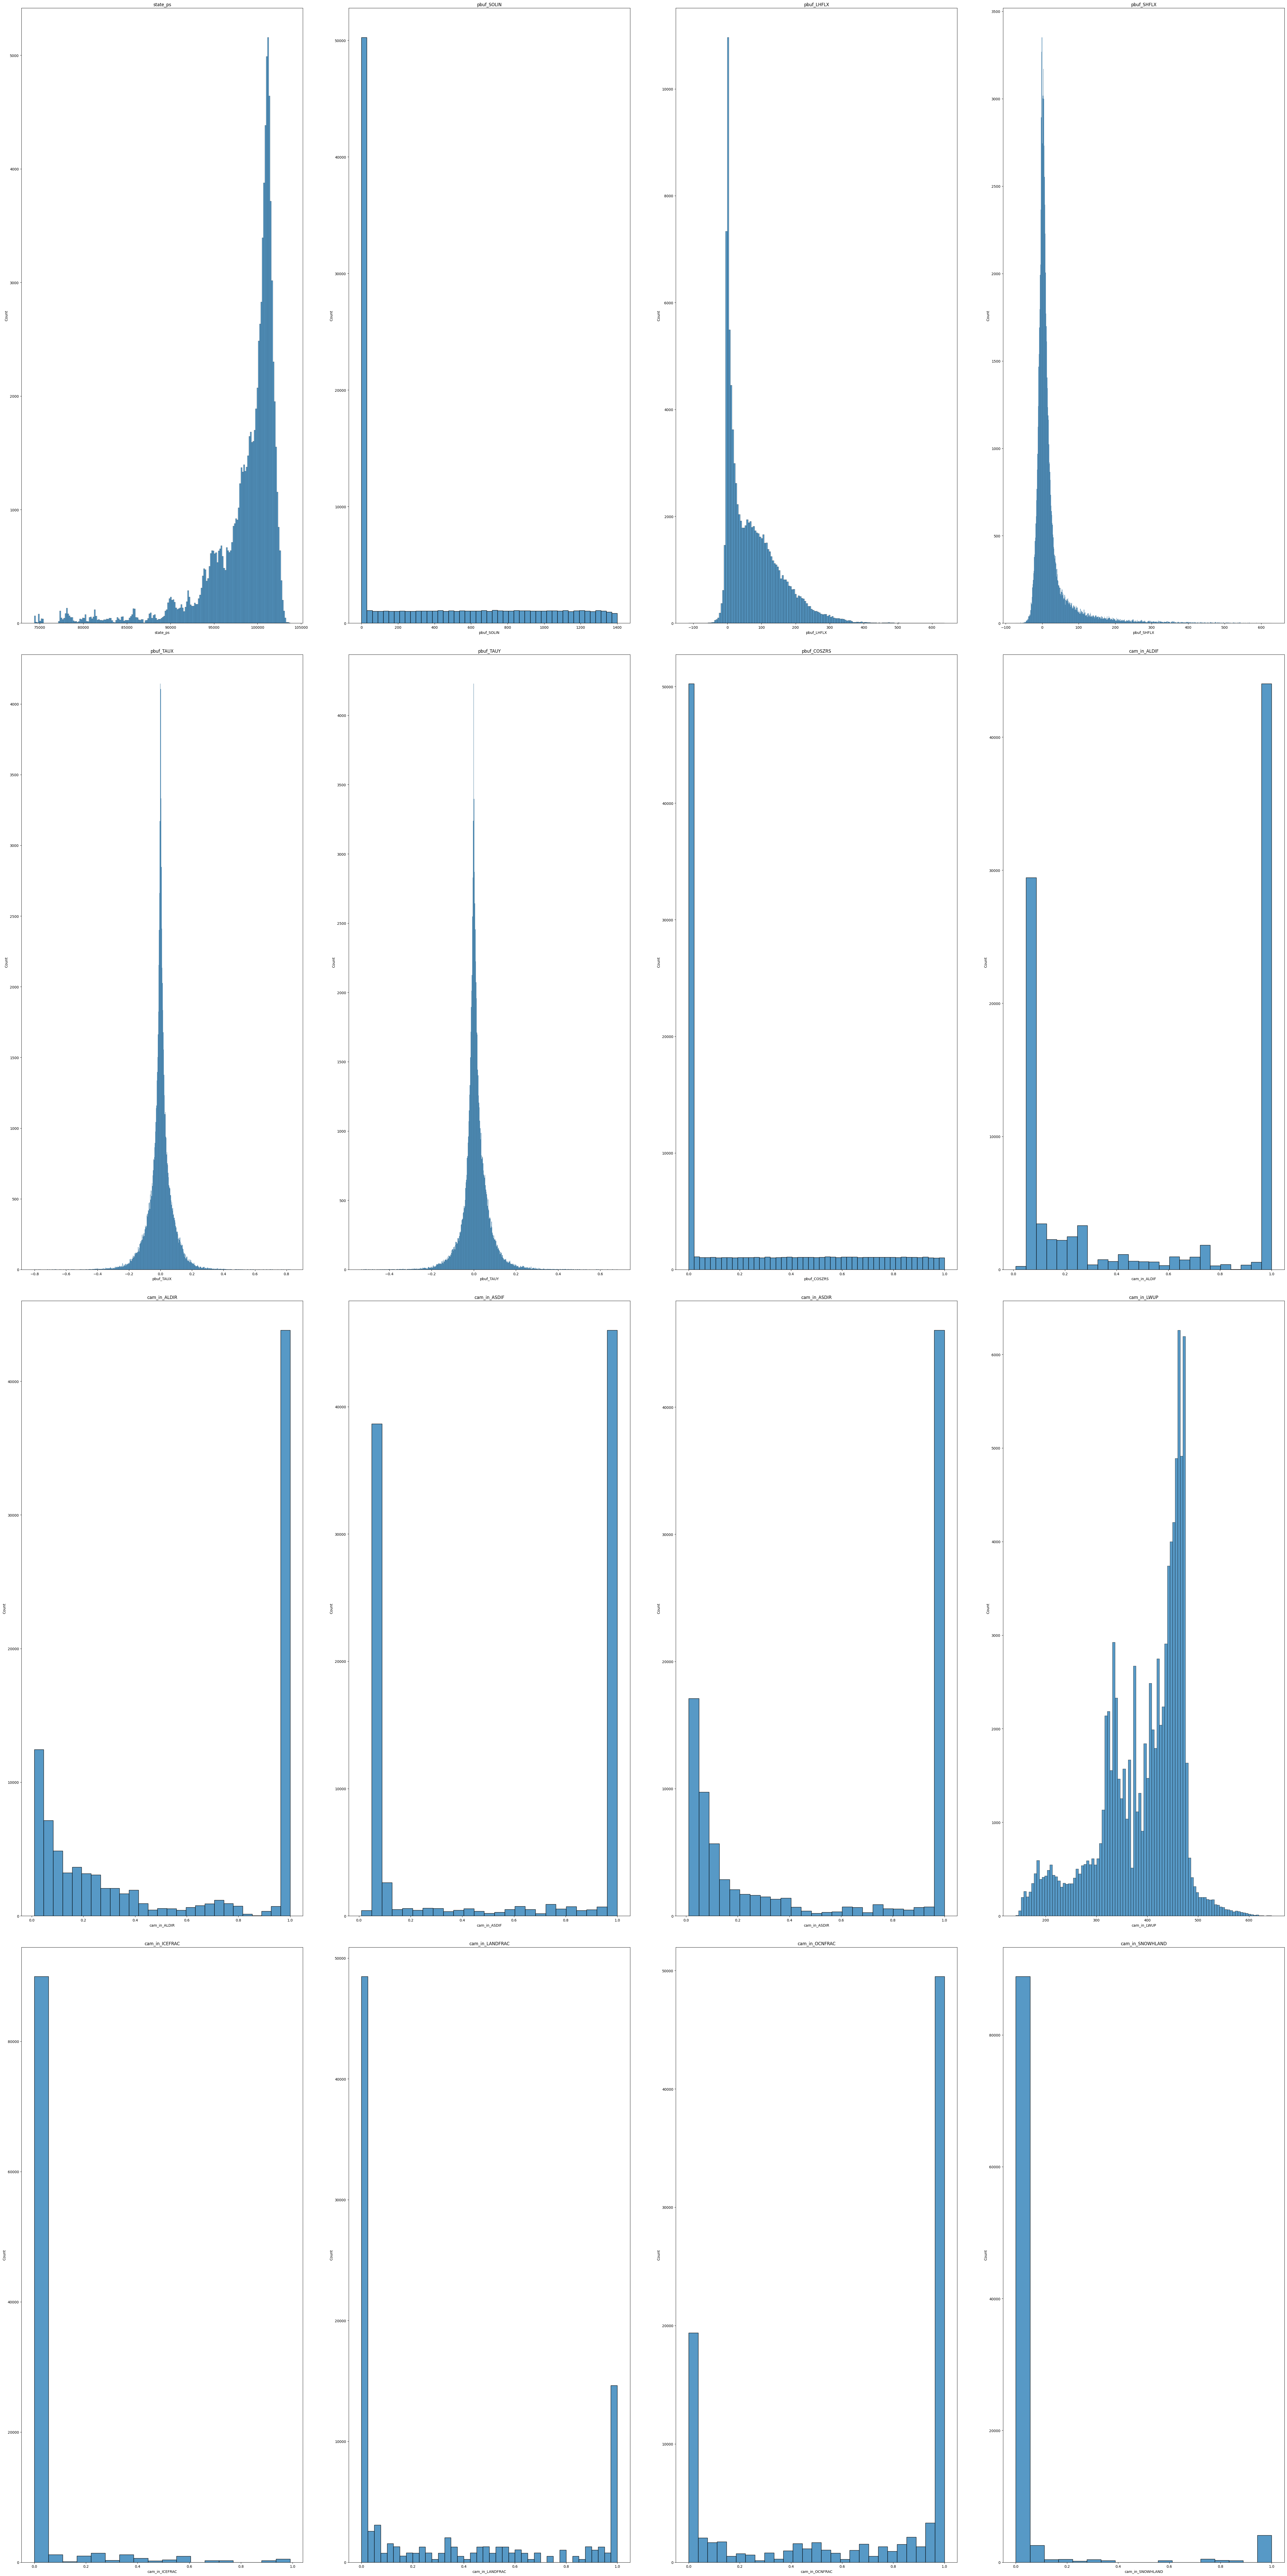

In [ ]:
display_batch_i_key_j(batch_id=0, key_id=-1, composit=False)

In [ ]:
# batch 2
input_data_batches[0][feature_scalers_cols].describe()


statistic,state_ps,pbuf_SOLIN,pbuf_LHFLX,pbuf_SHFLX,pbuf_TAUX,pbuf_TAUY,pbuf_COSZRS,cam_in_ALDIF,cam_in_ALDIR,cam_in_ASDIF,cam_in_ASDIR,cam_in_LWUP,cam_in_ICEFRAC,cam_in_LANDFRAC,cam_in_OCNFRAC,cam_in_SNOWHLAND
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0,98483.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",98595.201613,349.246315,72.748344,21.324078,-0.000445,0.008233,0.25029,0.559506,0.573994,0.554773,0.570079,393.737388,0.034489,0.299434,0.666078,0.059076
"""std""",4279.705877,449.745488,79.270393,56.626208,0.076331,0.062143,0.322311,0.429914,0.41882,0.448482,0.437321,81.255381,0.132155,0.38969,0.416546,0.214296
"""min""",74374.520339,0.0,-113.550462,-72.13772,-0.802122,-0.532576,0.0,0.009778,0.009778,0.009778,0.009778,141.303939,0.0,0.0,0.0,0.0
"""25%""",97631.43217,0.0,7.147869,-2.625129,-0.027061,-0.01442,0.0,0.061566,0.121322,0.06,0.077529,338.993904,0.0,0.0,0.144275,0.0
"""50%""",100136.620059,9.562197,49.320951,5.445516,0.00017,0.003239,0.006852,0.639994,0.651753,0.749133,0.757206,419.24087,0.0,0.030227,0.968388,0.0
"""75%""",101169.774572,699.031956,116.402177,20.557609,0.02778,0.030258,0.501015,1.0,1.0,1.0,1.0,457.92531,0.0,0.58091,1.0,0.0
"""max""",103736.641789,1400.578099,636.423749,628.722279,0.823058,0.680912,0.999657,1.0,1.0,1.0,1.0,644.560356,0.990222,1.0,1.0,1.00003


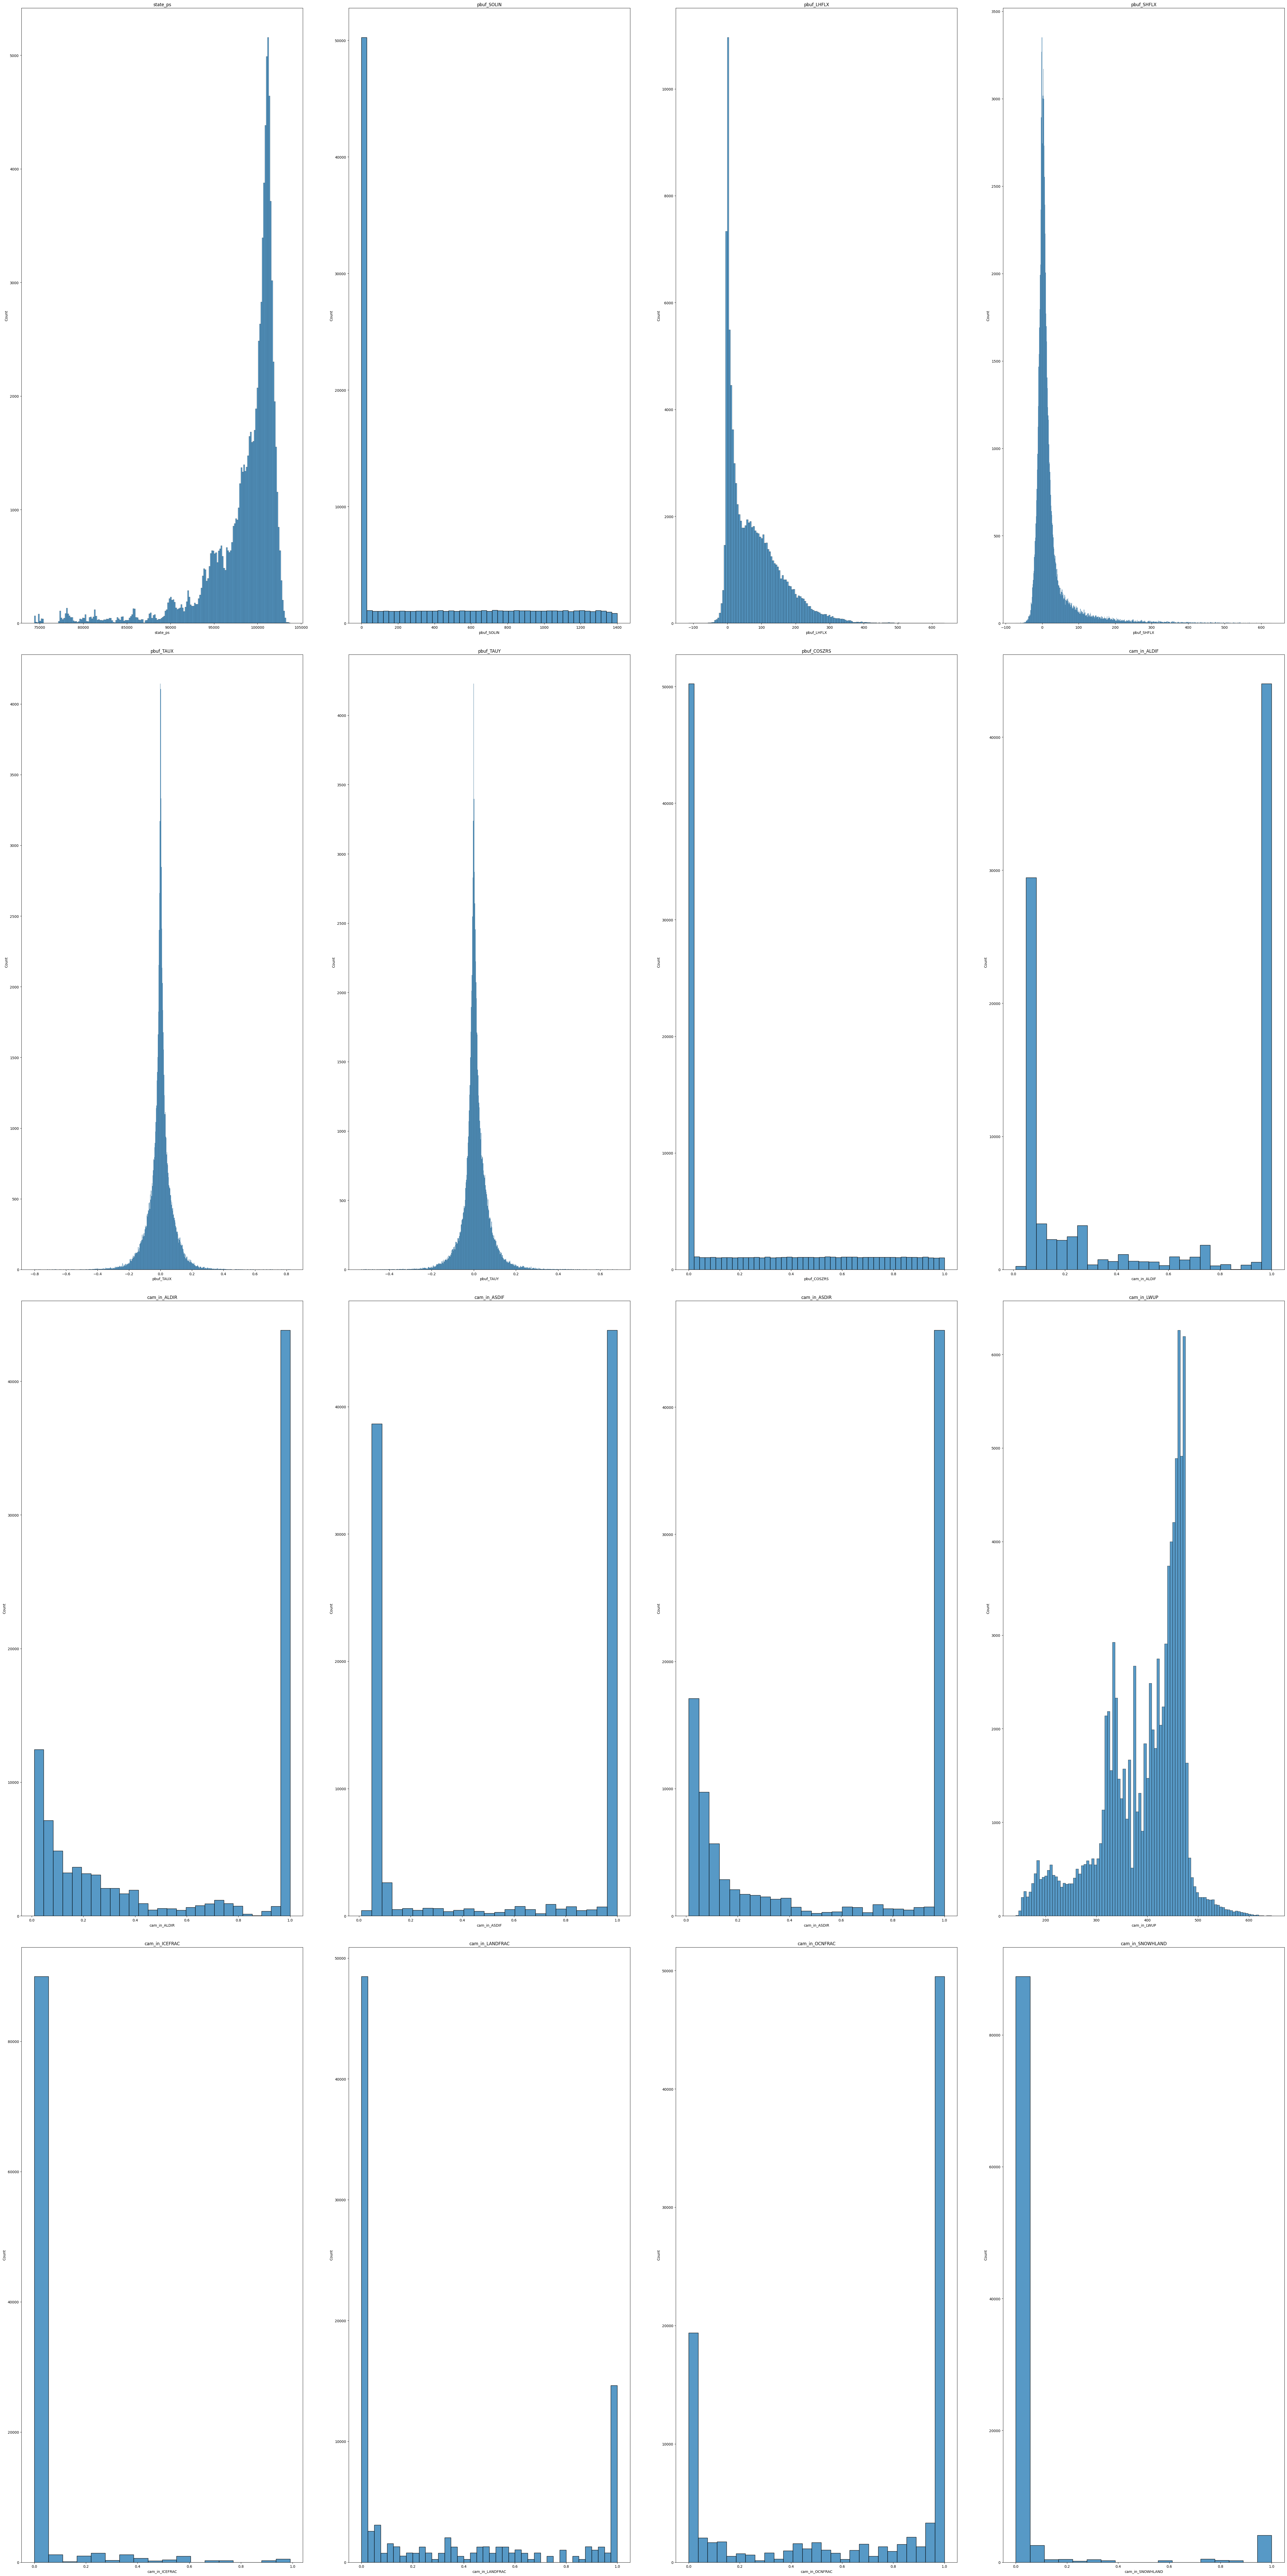

In [ ]:
display_batch_i_key_j(batch_id=0, key_id=-1, composit=False)

In [ ]:
from scipy import stats
from scipy.stats.mstats import pearsonr

df = input_data_batches[0].to_pandas()
df.drop('sample_id', axis=1, inplace=True)
correlationMatrix = pd.DataFrame(data=[],index=feature_scalers_cols, columns=feature_scalers_cols)
for i in feature_scalers_cols:
    for j in feature_scalers_cols:
        correlationMatrix.loc[i,j] = np.round(pearsonr(df.loc[:,i], df.loc[:,j])[0],2)


hc = correlationMatrix[correlationMatrix>0.8]
for col in correlationMatrix.columns:
    for idx in hc.index:
        if hc.loc[idx, col]>0.8 and idx != col:
            print(f"correlation of {idx}, {col}, is {hc.loc[idx, col]}")
#    df.index[df['points']>7].tolist()

correlation of pbuf_COSZRS, pbuf_SOLIN, is 1.0
correlation of pbuf_SOLIN, pbuf_COSZRS, is 1.0
correlation of cam_in_ALDIR, cam_in_ALDIF, is 0.99
correlation of cam_in_ASDIF, cam_in_ALDIF, is 0.99
correlation of cam_in_ASDIR, cam_in_ALDIF, is 0.98
correlation of cam_in_ALDIF, cam_in_ALDIR, is 0.99
correlation of cam_in_ASDIF, cam_in_ALDIR, is 0.98
correlation of cam_in_ASDIR, cam_in_ALDIR, is 0.99
correlation of cam_in_ALDIF, cam_in_ASDIF, is 0.99
correlation of cam_in_ALDIR, cam_in_ASDIF, is 0.98
correlation of cam_in_ASDIR, cam_in_ASDIF, is 0.99
correlation of cam_in_ALDIF, cam_in_ASDIR, is 0.98
correlation of cam_in_ALDIR, cam_in_ASDIR, is 0.99
correlation of cam_in_ASDIF, cam_in_ASDIR, is 0.99


### Observations

Looking thru the 2 sampled batches of data
<ol>
<li>Domains of the different distributions seem to span a wider range range than the previous feature</li>
<li>As opposed to the previous features, the features do not follow any trends - no strong correlation between the features</li>
</ol>



## <font color='red'> TODO Questions for Arvind </font>

<font color='red'> Can I use PCA to select relevant features from each composit feature separately then combine those in training the model</font>

## PCA to select the minimal set of features

In [ ]:
df = df[feature_scalers_cols]
df.head()

,state_ps,pbuf_SOLIN,pbuf_LHFLX,pbuf_SHFLX,pbuf_TAUX,pbuf_TAUY,pbuf_COSZRS,cam_in_ALDIF,cam_in_ALDIR,cam_in_ASDIF,cam_in_ASDIR,cam_in_LWUP,cam_in_ICEFRAC,cam_in_LANDFRAC,cam_in_OCNFRAC,cam_in_SNOWHLAND
0,101135.616333,0.0,89.488774,5.659510,0.005498,-0.012671,0.0,1.0,1.0,1.0,1.0,435.869227,0.0,0.000000,1.000000,0.0
1,101427.583863,0.0,102.340975,10.924796,-0.029348,-0.008927,0.0,1.0,1.0,1.0,1.0,418.813856,0.0,0.000000,1.000000,0.0
2,99069.424153,0.0,187.068130,6.692277,0.192057,-0.186918,0.0,1.0,1.0,1.0,1.0,454.118907,0.0,0.298189,0.701811,0.0
3,100786.588229,0.0,252.083263,34.809143,0.092754,-0.083188,0.0,1.0,1.0,1.0,1.0,458.833796,0.0,0.000000,1.000000,0.0
4,101229.487373,0.0,67.252308,9.070964,-0.020079,0.001456,0.0,1.0,1.0,1.0,1.0,406.082712,0.0,0.000000,1.000000,0.0


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# PCA for the scaler features

print(f"number of original features {len(feature_scalers_cols)}")
df = df[feature_scalers_cols]
df.head()
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Create a PCA object
pca = PCA(n_components=.98)  # Retaining 98% variance

# Fit PCA on the scaled data
pca.fit(scaled_data)

# Transform data into principal components
pca_data = pca.transform(scaled_data)

# Output the transformed data (principal components)
print(pca_data)

# The explained variance ratio to see how much information is retained
print("Explained variance ratio:", pca.explained_variance_ratio_)

number of original features 16
[[-1.74936591 -2.00007461 -0.25173783 ...  0.28895776 -0.02673888
   0.09093092]
 [-1.74188367 -1.99032305 -0.34205797 ...  0.11355546 -0.09738189
  -0.01406311]
 [-1.92715947 -1.48336675  0.57227966 ... -0.88471018  0.03539224
  -0.42841416]
 ...
 [ 1.65396127 -0.86507704 -1.12878969 ... -0.43273566  1.11447725
   0.47138766]
 [ 2.25900457 -0.89232456 -1.08761562 ... -1.11120708  0.62959218
  -0.02516766]
 [ 1.14560721 -0.10273102 -1.50451541 ... -0.39889647  1.1043705
   0.68718981]]
Explained variance ratio: [0.36362094 0.20845099 0.10306449 0.07806153 0.06141264 0.05145122
 0.04515587 0.03276672 0.02326986 0.01929455]


In [ ]:
# PCA for the state_p features

all_elts_of_composit_features['state_t']

print(f"number of original features {len(all_elts_of_composit_features['state_t'])}")
df = df[all_elts_of_composit_features['state_t']]
df.head()

number of original features 60


KeyError: "None of [Index(['state_t_0', 'state_t_1', 'state_t_2', 'state_t_3', 'state_t_4',\n       'state_t_5', 'state_t_6', 'state_t_7', 'state_t_8', 'state_t_9',\n       'state_t_10', 'state_t_11', 'state_t_12', 'state_t_13', 'state_t_14',\n       'state_t_15', 'state_t_16', 'state_t_17', 'state_t_18', 'state_t_19',\n       'state_t_20', 'state_t_21', 'state_t_22', 'state_t_23', 'state_t_24',\n       'state_t_25', 'state_t_26', 'state_t_27', 'state_t_28', 'state_t_29',\n       'state_t_30', 'state_t_31', 'state_t_32', 'state_t_33', 'state_t_34',\n       'state_t_35', 'state_t_36', 'state_t_37', 'state_t_38', 'state_t_39',\n       'state_t_40', 'state_t_41', 'state_t_42', 'state_t_43', 'state_t_44',\n       'state_t_45', 'state_t_46', 'state_t_47', 'state_t_48', 'state_t_49',\n       'state_t_50', 'state_t_51', 'state_t_52', 'state_t_53', 'state_t_54',\n       'state_t_55', 'state_t_56', 'state_t_57', 'state_t_58', 'state_t_59'],\n      dtype='object')] are in the [columns]"